In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import os

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='5GB')
client

D:\anacond\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60114 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60114/status,
Dashboard: http://127.0.0.1:60114/status,Workers: 2
Total threads: 4,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60115,Workers: 2
Dashboard: http://127.0.0.1:60114/status,Total threads: 4
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:60130,Total threads: 2
Dashboard: http://127.0.0.1:60133/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:60118,


# Read in data using Dask and Match up data

In [3]:
directory_path = './trade data/trade_data/'

# Generate the file pattern for the years 1975 to 2000
file_pattern = directory_path + 'BACI_HS12_Y{year}_V202001.csv'

file_patterns = [file_pattern.format(year=year) for year in range(2016, 2019)]

df = dd.read_csv(file_patterns,assume_missing=True)

df

,t,i,j,k,v,q
npartitions=16,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [4]:
import pandas as pd
products = pd.read_csv('./trade data/trade_data/product_codes_HS12_V202001.csv',encoding='latin-1')
products = products.rename(columns={"code":"k"})

In [6]:
df_wdes = df.merge(products)
df_wdes.head()

,t,i,j,k,v,q,description
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she..."
1,2016.0,4.0,586.0,80132.0,1.095,1.105,"Nuts, edible: cashew nuts, fresh or dried, she..."
2,2016.0,8.0,703.0,80132.0,27.977,2.793,"Nuts, edible: cashew nuts, fresh or dried, she..."
3,2016.0,16.0,251.0,80132.0,18.203,1.400,"Nuts, edible: cashew nuts, fresh or dried, she..."
4,2016.0,31.0,784.0,80132.0,1.970,0.517,"Nuts, edible: cashew nuts, fresh or dried, she..."


In [7]:
countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"i","iso_3digit_alpha":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"j","iso_3digit_alpha":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [7]:
df_wdes.head()

,t,i,j,k,v,q,description,name_i,name_j
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she...",AFG,DZA
1,2016.0,4.0,12.0,130190.0,1.507,0.585,"Natural gums, resins, gum-resins and oleoresin...",AFG,DZA
2,2016.0,4.0,12.0,370239.0,1.121,0.003,"Photographic film: in rolls, (other than with ...",AFG,DZA
3,2016.0,4.0,12.0,970600.0,17.236,0.019,Antiques: of an age exceeding one hundred years,AFG,DZA
4,2016.0,8.0,12.0,611020.0,1.226,0.035,"Jerseys, pullovers, cardigans, waistcoats and ...",ALB,DZA


# Describe the trade volume of the whole dataset in terms of value

In [8]:
trade_value_stats = df['v'].describe().compute()

# Print the descriptive statistics
print(trade_value_stats)

count    2.402566e+07
mean     2.090479e+03
std      6.687752e+04
min      1.000000e+00
25%      6.489589e+00
50%      3.579723e+01
75%      2.724135e+02
max      6.189576e+07
Name: v, dtype: float64


In [9]:
trade_value_stats = df['q'].describe().compute()

# Print the descriptive statistics
print(trade_value_stats)

count    2.402566e+07
mean     1.903036e+03
std      4.105983e+05
min      7.996801e-07
25%      3.230000e-01
50%      3.294068e+00
75%      3.964200e+01
max      8.246835e+08
Name: q, dtype: float64


# List the five highest value sectors in the entire sample period

In [12]:
# Mapping of HS code chapters to sectors
hs_to_sector = {
    **{f"{i:02}": "Animal & Animal Products" for i in range(1, 6)},  # 01-05
    **{f"{i:02}": "Vegetable Products" for i in range(6, 16)},       # 06-15
    **{f"{i:02}": "Foodstuffs" for i in range(16, 25)},              # 16-24
    **{f"{i:02}": "Mineral Products" for i in range(25, 28)},        # 25-27
    **{f"{i:02}": "Chemicals & Allied Industries" for i in range(28, 39)},  # 28-38
    **{f"{i:02}": "Plastics / Rubbers" for i in range(39, 41)},      # 39-40
    **{f"{i:02}": "Raw Hides, Skins, Leather, & Furs" for i in range(41, 44)},  # 41-43
    **{f"{i:02}": "Wood & Wood Products" for i in range(44, 50)},    # 44-49
    **{f"{i:02}": "Textiles" for i in range(50, 64)},                # 50-63
    **{f"{i:02}": "Footwear / Headgear" for i in range(64, 68)},     # 64-67
    **{f"{i:02}": "Stone / Glass" for i in range(68, 72)},           # 68-71
    **{f"{i:02}": "Metals" for i in range(72, 84)},                  # 72-83
    **{f"{i:02}": "Machinery / Electrical" for i in range(84, 86)},  # 84-85
    **{f"{i:02}": "Transportation" for i in range(86, 90)},          # 86-89
    **{f"{i:02}": "Miscellaneous" for i in range(90, 98)}            # 90-97
}

# Convert HS codes to string, handling NaNs and other non-string types gracefully
df_wdes['k'] = df_wdes['k'].astype(str)

# Now apply the mapping function
df_wdes['sector'] = df_wdes['k'].map(lambda x: hs_to_sector.get(x[:2], "Other"))

def get_sector(hs_code):
    # Ensure hs_code is a string and check if it's long enough
    hs_code = str(hs_code)
    if len(hs_code) >= 2:
        prefix = hs_code[:2]
        return hs_to_sector.get(prefix, "Other")
    return "Other"

import dask.dataframe as dd

# Apply the get_sector function
df_wdes['sector'] = df_wdes['k'].map(get_sector)

# Compute or persist to see results
df_wdes = df_wdes.persist()  # if using Dask distributed and need to keep in memory
# or
#result = df_wdes.compute()  # to execute all operations and bring data into memory

In [13]:
df_wdes.columns

Index(['t', 'i', 'j', 'k', 'v', 'q', 'description', 'name_i', 'name_j',
       'sector'],
      dtype='object')

In [14]:
# Group by the product name and sum the trade values
sector_trade_values = df_wdes.groupby('sector')['v'].sum()

# Compute the result to get the top five sectors with the highest trade values
top_five_sectors = sector_trade_values.nlargest(5).compute()

# Display the results
print("Top Five Sectors by Trade Value:")
print(top_five_sectors)

Top Five Sectors by Trade Value:
sector
Machinery / Electrical           1.312468e+10
Mineral Products                 6.489509e+09
Transportation                   5.519668e+09
Chemicals & Allied Industries    5.334477e+09
Metals                           3.945046e+09
Name: v, dtype: float64


# Who were the top 10 countries with the most trading partners

In [11]:
# Group by 'exporter_name' and count unique 'importer_name' to find the number of unique trading partners
trading_partners = df_wdes.groupby('name_i')['name_j'].nunique()

# Compute the result to get the top 10 countries with the most unique trading partners
top_10_countries = trading_partners.nlargest(10).compute()

# Display the results
print("Top 10 Countries with the Most Trading Partners:")
print(top_10_countries)

Top 10 Countries with the Most Trading Partners:
name_i
Germany                       220
Netherlands                   220
Brazil                        219
France, Monaco                219
Italy                         219
United Kingdom                219
Thailand                      218
Spain                         217
Switzerland, Liechtenstein    217
Sweden                        216
Name: name_j, dtype: int64


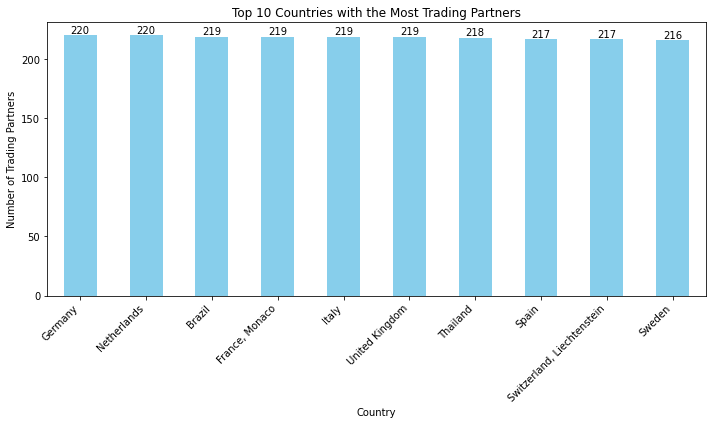

In [12]:
import matplotlib.pyplot as plt

# 创建图形和子图对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱形图
top_10_countries.plot(kind='bar', color='skyblue', ax=ax)

# 添加每个柱形上的合作伙伴数量文本标签
for i, v in enumerate(top_10_countries):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# 设置标题和标签
ax.set_title('Top 10 Countries with the Most Trading Partners')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Trading Partners')
ax.set_xticklabels(top_10_countries.index, rotation=45, ha='right')  # 设置x轴标签

# 显示图形
plt.tight_layout()
plt.show()

# Who were the bottom 10 countries with the fewest trading partners

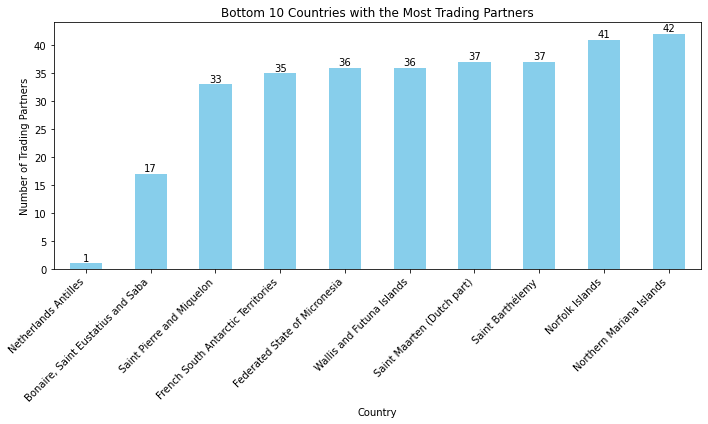

In [13]:
bottom_10_countries = trading_partners.nsmallest(10).compute()

# 创建图形和子图对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱形图
bottom_10_countries.plot(kind='bar', color='skyblue', ax=ax)

# 添加每个柱形上的合作伙伴数量文本标签
for i, v in enumerate(bottom_10_countries):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# 设置标题和标签
ax.set_title('Bottom 10 Countries with the Most Trading Partners')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Trading Partners')
ax.set_xticklabels(bottom_10_countries.index, rotation=45, ha='right')  # 设置x轴标签

# 显示图形
plt.tight_layout()
plt.show()

# Calculate the top 10 exports (in terms of value) of USA, EU in total, China, and Vietnam over the sample period (5 points)

In [8]:
# Dictionary of countries and their respective codes
countries = {
    'USA': 'USA',  # assuming 'USA' is the code used in your dataset
    'EU': ['GBR', 'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 
           'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'MLT', 'NLD', 
           'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'],  # EU country codes
    'China': 'CHN',
    'Vietnam': 'VNM'
}

# Create a list of all relevant exporter codes, including handling the single code and list of codes correctly
all_codes = [countries['USA'], countries['China'], countries['Vietnam']] + countries['EU']

# Filter data for USA, EU, China, and Vietnam using 'exporter_code'
filtered_data = df_wdes[df_wdes['name_i'].isin(all_codes)]

# Aggregate trade values by exporter and product
top_exports = filtered_data.groupby(['name_i', 'description'])['v'].sum()

# Compute the result to get top exports for each country or region
top_exports = top_exports.compute().sort_values(ascending=False).groupby('name_i').head(10)

# Since the data includes EU countries separately, we need to aggregate EU data
eu_exports = top_exports.loc[countries['EU']].groupby('description').sum()
eu_top_10_exports = eu_exports.nlargest(10)

# Display the results for each entity by checking and indexing properly
print("Top 10 Exports for USA:")
print(top_exports.loc[[countries['USA']]])
print("\nTop 10 Exports for China:")
print(top_exports.loc[[countries['China']]])
print("\nTop 10 Exports for Vietnam:")
print(top_exports.loc[[countries['Vietnam']]])
print("\nTop 10 Exports for EU:")
print(eu_top_10_exports)

Top 10 Exports for USA:
name_i  description                                                                                                                                                                                                                             
USA     Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    2.308764e+08
        Aeroplanes and other aircraft: of an unladen weight exceeding 15,000kg                                                                                                                                                                      1.604832e+08
        Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                                      

# Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of value and quantity

In [13]:
# Group by 'product_name' and sum the trade value 'v'
aggregated_trade_value = trade_data.groupby('description')['v'].sum()

# Compute the result to get the top 10 goods with the highest trade value
top_10_goods_by_value = aggregated_trade_value.nlargest(10).compute()

# Display the results
print("Top 10 Goods by Total Trade Value:")
print(top_10_goods_by_value)

Top 10 Goods by Total Trade Value:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.552373e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    1.829220e+09
Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc                                                                                                       8.573921e+08
Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                               

In [9]:
aggregated_trade_quantity = df_wdes.groupby('description')['q'].sum()
top_10_goods_by_quantity = aggregated_trade_quantity.nlargest(10).compute()

# Display the results
print("Top 10 Goods by Total Trade Quantity:")
print(top_10_goods_by_quantity)

Top 10 Goods by Total Trade Quantity:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      6.735505e+09
Iron ores and concentrates: non-agglomerated                                                                                                                                                                                                4.143942e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    3.799377e+09
Coal: bituminous, whether or not pulverised, but not agglomerated                                                                                                                                          

In [10]:
aggregated_trade_value = df_wdes.groupby('description')['q'].sum()
top_goods_by_value = df_wdes.groupby('description')['v'].sum().nlargest(10).compute()

print("Top 10 goods by trade value:")
print(top_goods_by_value)

Top 10 goods by trade value:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.552373e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    1.829220e+09
Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc                                                                                                       8.573921e+08
Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                                     

# Question 1.4
Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen
country and all the other centroids. You may use either haversine distance with the geographic
CRS or use a projected CRS and use the distance function of geopandas. (10 points).Please
also create a scatterplot of distance and export volume (quantity and value) in logarithm form (5
points)

In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [12]:
# Step 1: Load the shapefile
gdf = gpd.read_file('./countries_shapefile/cn_primary_countries.shp')

# Step 2: Calculate centroids
gdf['centroid'] = gdf.geometry.centroid

# Step 3: Find China's centroid
china_centroid = gdf[gdf['name'] == 'China']['centroid'].iloc[0]

C:\Users\huawei\AppData\Local\Temp\ipykernel_11772\795398480.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


In [13]:
gdf.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'geometry', 'centroid'],
      dtype='object')

In [14]:
# Step 4: Calculate distances using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

gdf['distance_to_china'] = gdf['centroid'].apply(lambda x: haversine(china_centroid.x, china_centroid.y, x.x, x.y))

trade_data_agg = df_wdes.groupby('name_i').agg({'v': 'sum', 'q': 'sum'}).compute()

In [16]:
# Convert GeoDataFrame to DataFrame for merging
geo_df = pd.DataFrame(gdf.drop(columns='geometry'))
geo_df.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'centroid', 'distance_to_china'],
      dtype='object')

In [24]:
geo_df = geo_df.rename(columns={"iso_a3":"name_i"})
geo_df = geo_df.rename(columns={"name_i":"iso_a3"})
geo_df.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'centroid', 'distance_to_china'],
      dtype='object')

In [25]:
# Merge geographic and trade data

merged_data = pd.merge(geo_df, trade_data_agg, left_on='iso_a3', right_on='name_i')

print(gdf[['iso_a3', 'distance_to_china']])

    iso_a3  distance_to_china
0      AFG        3427.944689
1      AGO       10489.123597
2      ALB        6985.295568
3      AND        8226.065852
4      ARE        4903.125626
..     ...                ...
188    WSM       10389.626066
189    YEM        5964.500594
190    ZAF       10970.788557
191    ZMB        9686.616650
192    ZWE        9901.954609

[193 rows x 2 columns]


In [26]:
import geopandas as gpd
import numpy as np

# If not already converted to a GeoDataFrame with lat and lon, you need to extract these from 'centroid' if possible
if 'longitude' not in merged_data.columns or 'latitude' not in merged_data.columns:
    merged_data['longitude'] = merged_data['centroid'].apply(lambda x: x.x)
    merged_data['latitude'] = merged_data['centroid'].apply(lambda x: x.y)

# Convert to GeoDataFrame if necessary
if not isinstance(merged_data, gpd.GeoDataFrame):
    merged_data = gpd.GeoDataFrame(merged_data, geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude))

C:\Users\huawei\AppData\Local\Temp\ipykernel_11772\2894521985.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


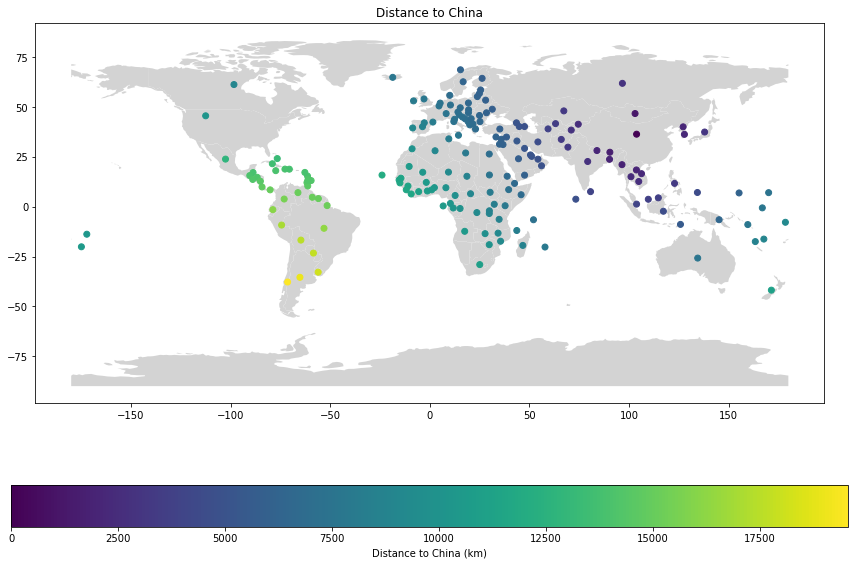

In [27]:
# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray')

# Plot distances using a color scale
merged_data.plot(ax=ax, column='distance_to_china', cmap='viridis', legend=True,
                 legend_kwds={'label': "Distance to China (km)", 'orientation': "horizontal"})

plt.title('Distance to China')
plt.show()

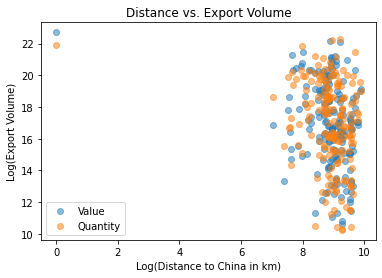

In [28]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(np.log1p(merged_data['distance_to_china']), np.log1p(merged_data['v']), label='Value', alpha=0.5)
ax.scatter(np.log1p(merged_data['distance_to_china']), np.log1p(merged_data['q']), label='Quantity', alpha=0.5)
ax.set_xlabel('Log(Distance to China in km)')
ax.set_ylabel('Log(Export Volume)')
ax.legend()
plt.title('Distance vs. Export Volume')
plt.show()

## Bonus Qs

Economic Intuition

For the question regarding which commodity sectors are most influenced by distance in terms of exporting, economic intuition suggests that several factors might be relevant:

Weight and Volume: Commodities that are bulkier or heavier (like raw materials and agricultural products) tend to have higher transportation costs, making distance a more critical factor.
Perishability: Perishable goods (such as fresh foods) may have limited export ranges due to the need for quicker delivery.
Value Density: High-value, low-volume goods (like electronics or pharmaceuticals) are less sensitive to distance because their transportation costs are a smaller proportion of their total value.
Market Dynamics: The necessity of goods in importing countries can also affect sensitivity to distance. Essential commodities might still be imported regardless of distance due to lack of local alternatives.
Data Requirements
To analyze how distance impacts the importance of exporting different commodity sectors, the following data would be needed:

Trade Data: Detailed records of trade flows between countries, including commodity sector, export quantities, and values.
Distance Data: Information on the distance between exporting and importing countries. This could be direct geographic distance or more complex measures that consider actual shipping routes or transportation infrastructure.
Commodity Characteristics: Data on the nature of the commodities being traded, including weight, volume, perishability, and value density.
Economic Indicators: GDP, population, and possibly economic openness of the trading countries, as these can influence trade volumes and patterns.

Data Manipulation

Merge and Clean Data: Combine trade, distance, and commodity characteristic data into a single dataset. Handle missing values and ensure consistent units across different sources.
Categorize Commodities: Group commodities into sectors based on their characteristics (e.g., perishable goods, heavy goods, high-value goods).
Compute Trade Weights: Create weighted measures of trade flows that consider both the quantity and the value of goods traded.

Analysis Strategy

Correlation Analysis: Calculate correlations between distance and trade volume/value for each commodity sector. This provides a preliminary view of which sectors are most impacted by distance.

Regression Analysis:

Perform econometric regressions where trade volume or value is the dependent variable, and distance, along with other economic indicators and commodity characteristics, are independent variables. Include interaction terms between distance and commodity characteristics to see if the impact of distance varies by these features.
Consider fixed effects for countries to control for unobserved heterogeneity.

Cluster Analysis:

Use clustering techniques to identify groups of commodity sectors based on their patterns of sensitivity to distance.

Visualization:

Plot scatter graphs of trade volume/value against distance for different commodity sectors.
Use heat maps to show the intensity of trade relationships over distances across different sectors.